In [1]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2
from tqdm import tqdm

from load_data import BiopsyDataset, get_balanced_dataloader, Nullmutation
from eval import get_accuracy_per_class

DATA_DIR = "../../data/biopsies_s1.0_anon_data/"
PATHXL_DIR = os.path.join(DATA_DIR, "..", "p53_consensus_study")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Device: {}".format(device))

# Load csv
csv_file = os.path.join(DATA_DIR, "biopsy_labels_anon_s1.0.csv")
df = pd.read_csv(csv_file)

pathxl_csv_file = os.path.join(PATHXL_DIR, "labels.csv")
pathxl_df = pd.read_csv(pathxl_csv_file)

C:\Users\321lu\AppData\Local\Temp\ipykernel_25888\3817817176.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Device: cuda


In [2]:
# Load ResNet18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
# ResNet18 is pretrained on images with size 224x224
num_ftrs = resnet18.fc.in_features
print("Number of features: {}".format(num_ftrs))
resnet18.fc = nn.Identity()

resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
# ResNet50 is pretrained on images with size 224x224
num_ftrs = resnet50.fc.in_features
print("Number of features: {}".format(num_ftrs))
resnet50.fc = nn.Identity()

Number of features: 512
Number of features: 2048


In [6]:
from resnet import ResNetModel
checkpoint_path = os.path.join(DATA_DIR, "..", "..", "models", "fb_spacing4", "acc0.74_epoch42_s4_e50_end-to-end_ks.ckpt")
# Load lightning model from checkpoint
resnet18_tuned = ResNetModel.load_from_checkpoint(checkpoint_path).to(device)
resnet18_tuned.eval()
resnet18_tuned.model.fc = nn.Identity()

MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1


In [8]:
from RetCCL.custom_objects import retccl_resnet50, HistoRetCCLResnet50_Weights

retccl = retccl_resnet50(weights=HistoRetCCLResnet50_Weights.RetCCLWeights).to(device)
# retccl is pretrained on images with size 256x256 at 1 micron per pixel
num_ftrs = retccl.fc.in_features
print("Number of features: {}".format(num_ftrs))
retccl.fc = nn.Identity()

Number of features: 2048


In [11]:
"""
df:
	id	label
0	0	2
1	1	2
2	2	2
3	3	2
4	4	2
...	...	...
1527	1527	2
1528	1528	2
1529	1529	0
1530	1530	0
1531	1531	0
"""


# ImageNet normalization
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                      std=[0.229, 0.224, 0.225]) # What this does is it subtracts the mean from each channel and divides by the std
])

TRANSFORM_NORMAL = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                      std=[0.5, 0.5, 0.5]) # What this does is it subtracts the mean from each channel and divides by the std
])

model_configs = {
    "resnet18": {
        "model": resnet18,
        "size": 224,
        "num_ftrs": 512,
        "transform": TRANSFORM,
        "spacing": 1.0, # Not actually fine-tuned on any spacing
    },
    "resnet50": {
        "model": resnet50,
        "size": 224,
        "num_ftrs": 2048,
        "transform": TRANSFORM,
        "spacing": 1.0, # Not actually fine-tuned on any spacing
    },
    "retccl": {
        "model": retccl,
        # "size": 256,
        "size": None,
        "num_ftrs": 2048,
        "transform": TRANSFORM,
        "spacing": 1.0,
    },
    "resnet18_tuned": {
        "model": resnet18_tuned, # Fine-tuned on FB dataset at 4mpp
        "size": 64,
        "num_ftrs": 512,
        "transform": TRANSFORM_NORMAL,
        "spacing": 4.0,
    }
}

# Full biopsies

In [9]:
spacing = 4

for model_name, model_config in model_configs.items():
    if model_name != "retccl":
        continue

    model = model_config["model"]
    model.eval()
    size = model_config["size"]
    if size == None:
        transform = TRANSFORM
        size = "Full"
    else:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((size, size)),
            TRANSFORM
        ])
    num_ftrs = model_config["num_ftrs"]

    # Open image from dataset
    latents = torch.zeros((len(df), 4, num_ftrs)) # 4 is the number of rotations
    latent_file = os.path.join(DATA_DIR, f"latents_s{spacing}_{model_name}.pt")
    if os.path.exists(latent_file):
        latents = torch.load(latent_file).detach()

    for idx, label in tqdm(df.values):
        if torch.any(latents[idx] != 0):
            continue

        img_path = os.path.join(DATA_DIR, "biopsies", f"{idx}.png")
        img = plt.imread(img_path) # HxWxC
        img = torch.tensor(img).permute(2,0,1)

        new_size = (img.shape[1]//spacing, img.shape[2]//spacing)
        # Apply resize transform
        img = torchvision.transforms.functional.resize(img, new_size)

        # Apply other transform
        img = transform(img).unsqueeze(0).float().to(device)

        # for i in range(4):
        #     img_rot = torch.rot90(img, i, [2,3])
        #     img_latent = model(img_rot)
        #     latents[idx, i] = img_latent.detach()

        with torch.no_grad():
            img_latent = model(img)
            latents[idx] = img_latent

        torch.save(latents, latent_file)

  0%|          | 0/1532 [00:00<?, ?it/s]c:\Users\321lu\.conda\envs\dl2023\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1532/1532 [11:32<00:00,  2.21it/s]


# Patches

In [29]:
from load_data import BagDataset, P53_CLASS_NAMES

model_name = "resnet18_tuned"
model_config = model_configs[model_name]
model = model_config["model"]
model.eval()
model = model.to(device)

size = model_config["size"]
resize_factor = 1 / model_config["spacing"]
transform = model_config["transform"]
quantile_range_threshold = 0.1
root_dir = DATA_DIR

num_ftrs = model_config["num_ftrs"]

# indices_filename = os.path.join(DATA_DIR, "non_empty_patch_indices_gs256_relaxed.pt")
# non_empty_patch_indices_by_biopsy = torch.load(indices_filename)

# Load latents
latent_file = os.path.join(DATA_DIR, f"bag_latents_gs{size}_{model_name}.pt")
# latent_file_backup = os.path.join(DATA_DIR, f"bag_latents_gs{size}_{model_name}_backup.pt")
if os.path.exists(latent_file):
    bag_latents = torch.load(latent_file)
else:
    bag_latents = {}
for idx, label in tqdm(df.values):
    if idx in bag_latents:
        continue
    # if idx in non_empty_patch_indices_by_biopsy:
    #     continue

    img_file = os.path.join(root_dir, "biopsies", f"{idx}.png")
    img = plt.imread(img_file)
    img = torch.tensor(img).permute(2, 0, 1).float() # (3, h, w)

    # Resize the img so that the height and width are multiples of grid_spacing, 
    # rounded to the nearest multiple.
    # This prevents the last row and column of patches from being cut off.
    # We also resize the image by the resize_factor instead of each patch separately
    new_size = (max(round(img.shape[1]*resize_factor/size), 1)*size, 
                max(round(img.shape[2]*resize_factor/size), 1)*size)
    img = torch.nn.functional.interpolate(img.unsqueeze(0), size=new_size, 
        mode='bilinear', align_corners=False)[0]

    patches = torch.nn.functional.unfold(img.unsqueeze(0), 
        kernel_size=(size, size), 
        stride=(size, size)) # (1, 3*size*size, n_patches)
    patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)
    
    # Remove patches with low difference between the 75th and 1st percentile
    qranges = torch.quantile(patches.view(patches.shape[0], -1), 0.75, dim=-1) - \
              torch.quantile(patches.view(patches.shape[0], -1), 0.01, dim=-1)
    non_empty_idx = torch.where(qranges >= quantile_range_threshold)[0]
    patches = transform(patches[non_empty_idx])
    patches = patches.to(device)

    # non_empty_patch_indices_by_biopsy[idx] = non_empty_idx

    with torch.no_grad():
        patch_latents = model(patches) # (n_patches, num_ftrs)
    bag_latents[idx] = patch_latents.cpu()[:, None, :] # (n_patches, 1, num_ftrs)

    if idx % 10 == 0:
        torch.save(bag_latents, latent_file)
        # torch.save(bag_latents, latent_file_backup)
    #     torch.save(non_empty_patch_indices_by_biopsy, indices_filename)

    # Clear memory
    del img, patches, patch_latents
    torch.cuda.empty_cache()

torch.save(bag_latents, latent_file)
# torch.save(bag_latents, latent_file_backup)
# torch.save(non_empty_patch_indices_by_biopsy, indices_filename)

100%|██████████| 1532/1532 [12:04<00:00,  2.12it/s]


In [ ]:
bag_latents = torch.load(os.path.join(DATA_DIR, "bag_latents_gs256_retccl.pt"))

print(type(bag_latents))
print(len(bag_latents))
print(bag_latents.keys())
print(bag_latents[0].shape)

In [16]:
# PathXL dataset

from load_data import BagDataset, P53_CLASS_NAMES

size = 256
quantile_range_threshold = 0.1
resize_factor = 1.0
root_dir = PATHXL_DIR

model_name = "retccl"
model_config = model_configs[model_name]
model = model_config["model"]
model.eval()
model = model.to(device)
num_ftrs = model_config["num_ftrs"]

indices_filename = os.path.join(PATHXL_DIR, "non_empty_patch_indices_gs256.pt")
if os.path.exists(indices_filename):
    non_empty_patch_indices_by_biopsy = torch.load(indices_filename)
else:
    non_empty_patch_indices_by_biopsy = {}

# Load latents
latent_file = os.path.join(PATHXL_DIR, f"bag_latents_gs{size}_{model_name}.pt")
if os.path.exists(latent_file):
    bag_latents = torch.load(latent_file)
else:
    bag_latents = {}
for i, row in tqdm(enumerate(pathxl_df.values), total=len(pathxl_df)):
    idx = f"{row[0]}_{row[1]}"
    if idx in bag_latents and idx in non_empty_patch_indices_by_biopsy:
        continue

    img_file = os.path.join(root_dir, "biopsies", f"{idx}.png")
    if not os.path.exists(img_file):
        print(f"File {img_file} does not exist")
        continue
    img = plt.imread(img_file)
    img = torch.tensor(img).permute(2, 0, 1).float() # (3, h, w)

    # Resize the img so that the height and width are multiples of grid_spacing, 
    # rounded to the nearest multiple.
    # This prevents the last row and column of patches from being cut off.
    # We also resize the image by the resize_factor instead of each patch separately
    new_size = (max(round(img.shape[1]*resize_factor/size), 1)*size, 
                max(round(img.shape[2]*resize_factor/size), 1)*size)
    img = torch.nn.functional.interpolate(img.unsqueeze(0), size=new_size, 
        mode='bilinear', align_corners=False)[0]

    patches = torch.nn.functional.unfold(img.unsqueeze(0), 
        kernel_size=(size, size), 
        stride=(size, size)) # (1, 3*size*size, n_patches)
    patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)
    
    # Remove patches with low difference between the 75th and 1st percentile
    qranges = torch.quantile(patches.view(patches.shape[0], -1), 0.75, dim=-1) - \
              torch.quantile(patches.view(patches.shape[0], -1), 0.01, dim=-1)
    non_empty_idx = torch.where(qranges >= quantile_range_threshold)[0]
    patches = TRANSFORM(patches[non_empty_idx])
    patches = patches.to(device)

    non_empty_patch_indices_by_biopsy[idx] = non_empty_idx

    with torch.no_grad():
        patch_latents = model(patches) # (n_patches, num_ftrs)
    bag_latents[idx] = patch_latents.cpu()[:, None, :] # (n_patches, 1, num_ftrs)

    if i % 10 == 0:
        torch.save(bag_latents, latent_file)
        torch.save(non_empty_patch_indices_by_biopsy, indices_filename)

    # Clear memory
    del img, patches, patch_latents
    torch.cuda.empty_cache()

torch.save(bag_latents, latent_file)
torch.save(non_empty_patch_indices_by_biopsy, indices_filename)

 84%|████████▍ | 549/650 [01:22<00:43,  2.33it/s]

File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_1.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_2.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_3.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_5.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_6.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_7.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_8.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_9.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_10.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_11.png does not exist
File ../../data/biopsies_s1.

100%|██████████| 650/650 [08:43<00:00,  1.24it/s]


File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\158_4.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\161_1.png does not exist
File ../../data/biopsies_s1.0_anon_data/..\p53_consensus_study\biopsies\161_3.png does not exist


# Test how padding affects the output

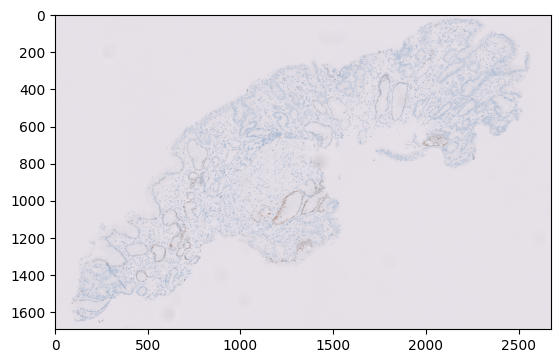

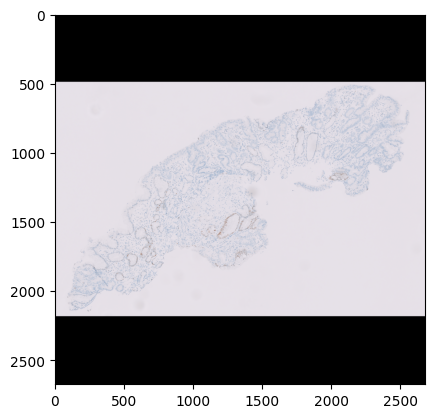

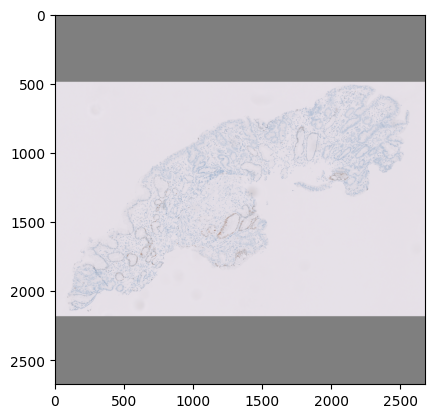

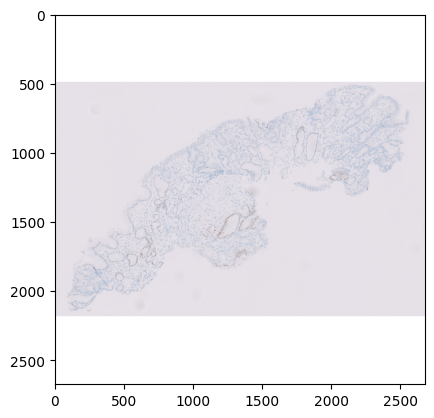

In [25]:
model = model_configs["resnet18"]["model"]

img_path = os.path.join(DATA_DIR, "biopsies", f"{df.iloc[0,0]}.png")
img = plt.imread(img_path) # HxWxC
plt.imshow(img)
plt.show()

img = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)
img_latent = model(img)
img_latent_padded = {}
pad = 0
if img.shape[2] != img.shape[3]:
    pad = abs(img.shape[2] - img.shape[3]) // 2
for pad_value in [0, 0.5, 1]:
    if img.shape[2] > img.shape[3]:
        img_pad = torch.nn.functional.pad(img, (pad, pad,0,0), value=pad_value)
    else:
        img_pad = torch.nn.functional.pad(img, (0,0,pad,pad), value=pad_value)

    # Show again
    show_img = img_pad.squeeze().permute(1,2,0).cpu().numpy()
    plt.imshow(show_img)
    plt.show()

    img_latent_padded[pad_value] = model(img_pad)

In [28]:
for img_latent_pad in img_latent_padded.values():
    # print(img_latent_pad - img_latent)

    # Print MSE between the two
    print(torch.nn.functional.mse_loss(img_latent, img_latent_pad))

    # Did the padding change the latent representation?
    print(torch.allclose(img_latent, img_latent_pad))

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
False
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
False
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
False
